### Fine tune LLM embeedings model


In [2]:
#!pip install openai==0.28.1
#!pip install openai --upgrade
#!pip install ragas
#!pip install unstructured
#!pip install langchain[all]
#!pip install --upgrade langchain

#!pip install playwright
#!pip install -U selenium unstructured
#!pip install --upgrade langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

In [1]:
#!pip install pydantic==2.5
#!pip install --upgrade --quiet  langchain_milvus
#!pip install --upgrade scipy

In [1]:
import os, json
#import openai
#from langchain.chat_models import ChatOpenAI, ChatGooglePalm
from utils import OPENAI_API_KEY

os.environ['OPENAI_API_KEY'] =  OPENAI_API_KEY
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from transformers import (BertTokenizer, 
                          BertModel,
                          BertForMaskedLM, 
                          Trainer, 
                          TrainingArguments, 
                          DataCollatorForLanguageModeling,
                          DataCollatorForWholeWordMask,
                          DataCollatorWithPadding
                         )
from datasets import load_dataset


### Load Model

In [4]:
# Load a tokenizer specific to BAAI/bge-base-en-v1.5
tokenizer = BertTokenizer.from_pretrained('BAAI/bge-base-en-v1.5')

# Load the BAAI/bge-base-en-v1.5 model for masked language modeling
model = BertModel.from_pretrained('BAAI/bge-base-en-v1.5')

In [5]:
tokenizer.tokenize_chinese_chars = False

In [6]:
# Load a dataset
parrent_dir = os.path.dirname(os.getcwd())
dataset = load_dataset('text', 
             data_files={'train':  './data/data_rag/file_train_chunks.json', 
                        'validation': './data/data_rag/file_validation_chunks.json'
                        })


In [7]:
# Tokenize the dataset and apply masking
def tokenize_function(examples):
    return tokenizer(examples['text'], 
                     return_tensors='pt', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


In [8]:
dataset['train']['text'][10]

'{text: In this work, we propose a method for predicting the energetic and electronic structures of defects in 2D materials with machine learning.  Firstly, a machine learning-friendly 2D Material Defect database (2DMD) was established employing high throughput DFT calculations15.  The database is composed of both structured datasets and dispersive datasets of defects in represented 2D materials such as MoS2, WSe2, h-BN, GaSe, InSe, and black phosphorous (BP).}'

In [9]:
print(len(tokenized_datasets['train'][10]['input_ids'])) # 512
print(tokenized_datasets['train'][11]['input_ids'])
type(torch.tensor(tokenized_datasets['train'][11]['input_ids']))

512
[101, 1063, 3793, 1024, 2057, 2224, 1996, 2951, 13462, 2015, 2000, 16157, 1996, 2836, 1997, 1996, 3130, 2988, 8107, 2247, 2007, 14635, 1521, 2029, 2001, 11974, 2881, 2000, 3073, 8321, 6412, 1997, 4475, 2007, 18419, 1012, 2256, 15078, 7885, 2265, 2008, 2256, 3921, 3640, 1037, 3278, 3623, 1999, 17547, 10640, 4102, 2000, 1996, 2110, 1011, 1997, 1011, 1996, 1011, 2396, 2236, 4725, 1012, 1065, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

torch.Tensor

#### LOAD Fine tuning model

In [10]:
# Load the model from the checkpoint directory
model_fm = BertModel.from_pretrained('./results512/checkpoint-4500')
model_fm.eval()
model.eval() # set the model in evaluation mode

Some weights of BertModel were not initialized from the model checkpoint at ./results512/checkpoint-4500 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

#### Embedding model BAAI/bge-base-en-v1.5

In [11]:
def get_embeeding(texts, model, tokenizer):
    
    model.eval() # set the model in evaluation mode
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # The last hidden state is used as embeddings
        embeddings = outputs.last_hidden_state

    return embeddings, outputs

In [12]:
emb, out = get_embeeding(dataset['train']['text'], model, tokenizer)

In [13]:
print(emb.shape) # Shape:(batch_size, sequence_length, hidden_size)
pooled_emb = out.pooler_output.numpy()
print(pooled_emb.shape) # Shape: (batch_size, hidden_size)


torch.Size([185, 512, 768])
(185, 768)


#### Embedding model BAAI/bge-base-en-v1.5 fine-tuned

In [14]:
emb_fm, out_fm = get_embeeding(dataset['train']['text'], model_fm, tokenizer)

In [15]:
print(emb_fm.shape) # Shape:(batch_size, sequence_length, hidden_size)
pooled_emb_fm = out_fm.pooler_output.numpy()
print(pooled_emb_fm.shape) # Shape: (batch_size, hidden_size)


torch.Size([185, 512, 768])
(185, 768)


#### LOAD QUESITONs

In [16]:
with open("data/data_rag/Sparse representation - questions.txt") as f:
    questions = f.read().splitlines()

questions = [q[1:].strip() for q in questions if q[0]=="*"]

questions

['Which materials are in the dataset?',
 'How many structures are there in the dataset?',
 'How to obtain the dataset?',
 'What is the dataset license?',
 'What is the data format?',
 'How to read the dataset?',
 'How to browse the dataset?',
 'Can I work with the dataset without Python?',
 'How to obtain the raw VASP files?',
 'What were the settings used for the DFT computations?',
 'How well the DFT calculations correspond to experiment?',
 'How to cite the dataset?',
 'What was the procedure for SRGNN quality evaluation?',
 'How is SRGNN different from the baselines?',
 'What are the limitations of SRGNN?',
 'What is the core idea of SRGNN?',
 'How to run the code?',
 'Which frameworks were used for SRGNN implementation?',
 'Can SRGNN be developed on a CPU, not a GPU?',
 'What is the code license?',
 'How to cite the code?',
 'Which materials has the SRGNN been trained on?',
 'Which materials can the SRGNN be trained on?',
 'Which defect types can the SRGNN be trained on?',
 'How m

#### Get quetions embeddings

In [17]:
q_embeddings, q_out = get_embeeding(questions, model, tokenizer)

In [18]:
q_embeddings_fm, q_out_fm = get_embeeding(questions, model_fm, tokenizer)

In [19]:
pooled_q_emb = q_out.pooler_output.numpy()
pooled_q_emb_fm = q_out_fm.pooler_output.numpy()

### Compare embeddings

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [21]:
# Compute cosine similarity between query embeddings and document embeddings
similarity_model = cosine_similarity(pooled_q_emb, pooled_emb)
similarity_model_fm = cosine_similarity(pooled_q_emb_fm, pooled_emb_fm)


In [22]:
def print_top_k_similarities(texts, k=5, embeddings=None, model=None, tokenizer=None):
    
    if embeddings is None:
        print("NONE")
        _, out = get_embeeding(texts, model, tokenizer)
        embeddings = out.pooler_output.numpy() # Shape: (batch_size, hidden_size)
    
    similarity_score = cosine_similarity(embeddings, embeddings)
    #print(similarity_score.shape)
    for i, s in enumerate(texts):
        top_k_indices = np.argsort(-similarity_score[i])[:k]
        print(f"Text: {s}")
        for j in top_k_indices:
            print(f"Similarity score: {similarity_score[i][j]:.4f}")
            print(f"Similar text: {texts[j]}")
            print()
        print("*"*15)
        
#np.argsort(-cosine_similarity(pooled_q_emb, pooled_q_emb))

In [23]:
print_top_k_similarities(questions, k=3, embeddings=pooled_q_emb)

Text: Which materials are in the dataset?
Similarity score: 1.0000
Similar text: Which materials are in the dataset?

Similarity score: 0.9864
Similar text: How many structures are there in the dataset?

Similarity score: 0.9796
Similar text: How to read the dataset?

***************
Text: How many structures are there in the dataset?
Similarity score: 1.0000
Similar text: How many structures are there in the dataset?

Similarity score: 0.9864
Similar text: Which materials are in the dataset?

Similarity score: 0.9857
Similar text: How to read the dataset?

***************
Text: How to obtain the dataset?
Similarity score: 1.0000
Similar text: How to obtain the dataset?

Similarity score: 0.9898
Similar text: How to read the dataset?

Similarity score: 0.9890
Similar text: What is the data format?

***************
Text: What is the dataset license?
Similarity score: 1.0000
Similar text: What is the dataset license?

Similarity score: 0.9829
Similar text: How to obtain the dataset?

Sim

In [24]:
print_top_k_similarities(questions, k=3, embeddings=pooled_q_emb_fm)

Text: Which materials are in the dataset?
Similarity score: 1.0000
Similar text: Which materials are in the dataset?

Similarity score: 0.7052
Similar text: How to browse the dataset?

Similarity score: 0.6458
Similar text: How to read the dataset?

***************
Text: How many structures are there in the dataset?
Similarity score: 1.0000
Similar text: How many structures are there in the dataset?

Similarity score: 0.7324
Similar text: How to browse the dataset?

Similarity score: 0.6686
Similar text: How to read the dataset?

***************
Text: How to obtain the dataset?
Similarity score: 1.0000
Similar text: How to obtain the dataset?

Similarity score: 0.7742
Similar text: How to browse the dataset?

Similarity score: 0.7271
Similar text: How to read the dataset?

***************
Text: What is the dataset license?
Similarity score: 1.0000
Similar text: What is the dataset license?

Similarity score: 0.9047
Similar text: What is the code license?

Similarity score: 0.6001
Simil

In [25]:
def print_similarities(similarity_model, questions, k=5):
    for i, q in enumerate(questions):
        print(f"Question: {q}")
        print()
        top_k = np.argsort(-similarity_model[i])[:k]
        print(f"Similarity Model: {top_k}")
        for j in top_k:
            print(f"Answer {j} score {similarity_model[i][j]:.3f}: {dataset['train']['text'][j]}")
            print()
        print("*"*15)
        #print()

In [26]:
print_similarities(similarity_model, questions, k=3)

Question: Which materials are in the dataset?

Similarity Model: [134 118 117]
Answer 134 score 0.988: {text: Moreover, our datasets could serve as a platform for competitive model training, and with the enrollments of more and more datasets, scalable defect prediction would be expected.  Results  Defect space and the structure of the 2DMD datasets  The defect space in 2D materials is mainly attributed to three aspects of variables, i.e.  the 2D material hosts, the defect components, and the defect configurations (Fig.  1a).}

Answer 118 score 0.988: {text: Our study provides a data-driven physical understanding of complex behaviors of defect properties in 2D materials, holding promise for a guide to the development of efficient machine learning models.  In addition, with the increasing enrollment of datasets, our database could provide a platform for designing materials with predetermined properties.}

Answer 117 score 0.988: {text: We develop a platform for easy implementation of mac

In [27]:
print_similarities(similarity_model_fm, questions, k=3)

Question: Which materials are in the dataset?

Similarity Model: [118 126 134]
Answer 118 score 0.589: {text: Our study provides a data-driven physical understanding of complex behaviors of defect properties in 2D materials, holding promise for a guide to the development of efficient machine learning models.  In addition, with the increasing enrollment of datasets, our database could provide a platform for designing materials with predetermined properties.}

Answer 126 score 0.582: {text: The properties of each new defect has to be calculated from scratch.  The state-of-the-art research paradigm integrated of high throughput simulations, data science, and machine learning is appealing to accelerate material exploration.}

Answer 134 score 0.565: {text: Moreover, our datasets could serve as a platform for competitive model training, and with the enrollments of more and more datasets, scalable defect prediction would be expected.  Results  Defect space and the structure of the 2DMD datas

In [28]:
def get_embeeding4path(texts, model_path, tokenizer_path):
    
    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    
    # Load the model from the checkpoint directory
    model = BertModel.from_pretrained(model_path)
    model.eval()
    
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # The last hidden state is used as embeddings
        embeddings = outputs.last_hidden_state

    return embeddings, outputs



In [29]:
model_128 =  BertModel.from_pretrained('./results128/checkpoint-9000')

_emb, _out = get_embeeding(dataset['train']['text'],  model_128, tokenizer)

Some weights of BertModel were not initialized from the model checkpoint at ./results128/checkpoint-9000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
emb_128 = _out.pooler_output.numpy()

In [31]:
_, _out = get_embeeding(questions,  model_128, tokenizer)
pooled_q_emb_128 = _out.pooler_output.numpy()

In [32]:
similarity_model_128 = cosine_similarity(pooled_q_emb_128, emb_128)

In [33]:
print_similarities(similarity_model_128, questions, k=3)

Question: Which materials are in the dataset?

Similarity Model: [ 27  42 140]
Answer 27 score 1.000: {text: The structures with defects present a challenge to machine learning algorithms.  The neighborhoods of the majority of the atoms are not affected by the point defects.  In principle, this shouldn’t be an obstacle for a perfect algorithm.  In practice, however, this comparatively small difference in the full structures is hard to learn.}

Answer 42 score 1.000: {text: The datasets as designed could provide training data for AI methods both the fine features of quantum mechanic nature and those features associated with different elements, crystal structures, and defect concentrations.  We used Density Functional Theory (DFT) for computing the properties, the details are described in the subsection “DFT computations”  The ‘Mo’ and two ‘S’ columns denote the the type of site that is being perturbed either by substituting the listed element, or a vacancy (vac).}

Answer 140 score 1.00

In [34]:
print("Mean std of chunks embeddings")
print(f"Pre-trained model: {pooled_emb.std(axis=0).mean()}")
print(f"Fine-tuning model: {pooled_emb_fm.std(axis=0).mean()}")

Mean std of chunks embeddings
Pre-trained model: 0.09223686903715134
Fine-tuning model: 0.24208326637744904


In [35]:
print("Median std of chunks embeddings")
print(f"Pre-trained model: {np.median(pooled_emb.std(axis=0))}")
print(f"Fine-tuning model: {np.median(pooled_emb_fm.std(axis=0))}")

Median std of chunks embeddings
Pre-trained model: 0.10071142017841339
Fine-tuning model: 0.24032855033874512


In [36]:
print("Minimum std of chunks embeddings")
print(f"Pre-trained model: {np.min(pooled_emb.std(axis=0))}")
print(f"Fine-tuning model: {np.min(pooled_emb_fm.std(axis=0))}")

Minimum std of chunks embeddings
Pre-trained model: 1.3542551187128993e-06
Fine-tuning model: 0.17343926429748535


In [49]:
cosine_sim = cosine_similarity(pooled_emb, pooled_emb)

cosine_sim_fm = cosine_similarity(pooled_emb_fm, pooled_emb_fm)

print('Mean cosine similarity between chrunks embeddings:')
print(f'Pre-trained model {cosine_sim.mean()} std ={cosine_sim.std()},')
print(f'Fine-tuning model {cosine_sim_fm.mean()} std ={cosine_sim_fm.std()}')

Mean cosine similarity between chrunks embeddings:
Pre-trained model 0.9726683497428894 std =0.01729932427406311,
Fine-tuning model 0.3229646682739258 std =0.13539975881576538


### Show embeddings

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 185 samples in 0.002s...
[t-SNE] Computed neighbors for 185 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 185 / 185
[t-SNE] Mean sigma: 1.304411
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.697712
[t-SNE] KL divergence after 300 iterations: 0.586698
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 185 samples in 0.000s...
[t-SNE] Computed neighbors for 185 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 185 / 185
[t-SNE] Mean sigma: 3.245960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.198795
[t-SNE] KL divergence after 300 iterations: 0.697580


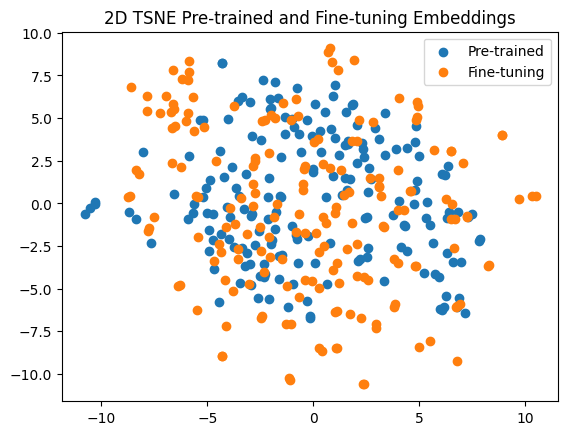

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

# Pre-trained model embeddins to 2D
tsne_results = tsne.fit_transform(np.array(pooled_emb))

tsne_results = tsne_results.transpose()

# Fine-tuning model embeddins to 2D
tsne_results_fm = tsne.fit_transform(np.array(pooled_emb_fm))

tsne_results_fm = tsne_results_fm.transpose()

# Plot the result
plt.scatter(tsne_results[0], tsne_results[1])
plt.scatter(tsne_results_fm[0], tsne_results_fm[1])
plt.title("2D TSNE Pre-trained and Fine-tuning Embeddings")
plt.legend(["Pre-trained", "Fine-tuning"])
plt.show()

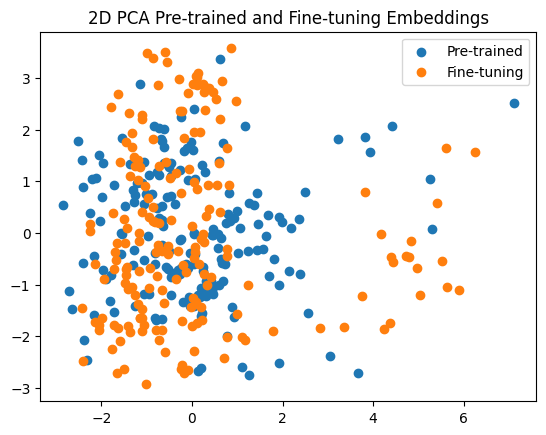

In [38]:
pca = PCA(n_components=2)

# Pre-trained model embeddins to 2D
reduced = pca.fit_transform(pooled_emb)
r_emb = reduced.transpose()

# Fine-tuning model embeddins to 2D
reduced_fm = pca.fit_transform(pooled_emb_fm)
r_emb_fm = reduced_fm.transpose()

plt.scatter(r_emb[0], r_emb[1])
plt.scatter(r_emb_fm[0], r_emb_fm[1])
plt.title("2D PCA Pre-trained and Fine-tuning Embeddings")
plt.legend(["Pre-trained", "Fine-tuning"])
plt.show()